### <center>San Jose State University<br>Department of Applied Data Science<br><br>**DATA 200<br>Computational Programming for Data Analytics**<br><br>Spring 2023<br>Instructor: Ron Mak</center>

# Database Design Example: Car Dealership

#### Design a database for the sales manager of Golden Lemon Used Car Dealership to keep track of which salesperson sold which vehicles to which customers during each month:
- A salesperson creates transactions to sell vehicles to customers.
- Each transaction includes the month it occurred.
- A transaction can include many vehicles, but at least one.
- Each sold vehicle is included in a single transaction.
- A transaction belongs to only one customer.
- A customer have many transactions, but at least one. A customer can have transactions with different salespeople. 
- Each salesperson has a name.
- Each customer has a name and gender.
- Each vehicles has a vechicle identification number (VIN), make, model, year, and price.

## Conceptual: ER diagram

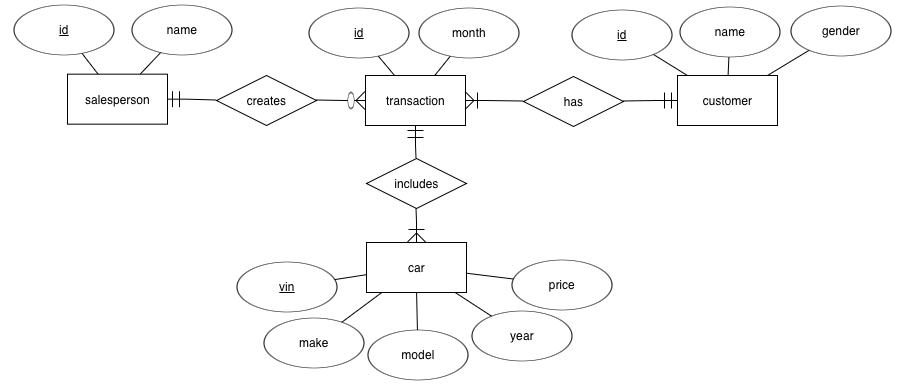

## Logical: Relational schema

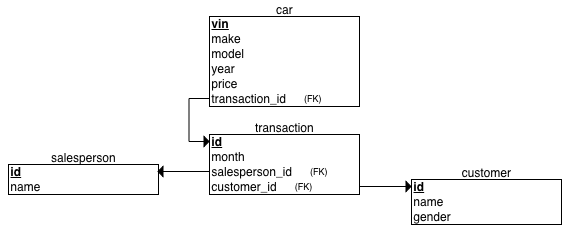

## Physical: Relational tables

In [ ]:
from DATA225utils import make_connection, dataframe_query

In [ ]:
conn = make_connection(config_file = 'CarDealership.ini')
cursor = conn.cursor()

In [ ]:
cursor.execute('DROP TABLE IF EXISTS car')
cursor.execute('DROP TABLE IF EXISTS transaction')
cursor.execute('DROP TABLE IF EXISTS customer')
cursor.execute('DROP TABLE IF EXISTS salesperson')

In [ ]:
cursor.execute( 
    """
    CREATE TABLE salesperson
    (
        id   VARCHAR(4)  NOT NULL,
        name VARCHAR(32) NOT NULL,
        PRIMARY KEY (id)
    )
    """
              )

cursor.execute( 
    """
    INSERT INTO salesperson
    VALUES ('SP11', 'Sarah'),
           ('SP22', 'Leslie'),
           ('SP33', 'Steve'),
           ('SP44', 'Judy'),
           ('SP55', 'Bruno')

    """
              )

conn.commit()

_, df = dataframe_query(conn, 'SELECT * FROM salesperson')
df

In [ ]:
cursor.execute( 
    """
    CREATE TABLE customer
    (
        id     VARCHAR(4)  NOT NULL,
        name   VARCHAR(32) NOT NULL,
        gender CHAR        NOT NULL,
        PRIMARY KEY (id)
    )
    """
              )

cursor.execute( 
    """
    INSERT INTO customer
    VALUES ('C111', 'Ron',    'm'),
           ('C222', 'Mara',   'f'),
           ('C333', 'Tom',    'm'),
           ('C444', 'Susan',  'f'),
           ('C555', 'Marsha', 'f'),
           ('C666', 'Max',    'm'),
           ('C777', 'Arnold', 'm')

    """
              )

conn.commit()

_, df = dataframe_query(conn, 'SELECT * FROM customer')
df

In [ ]:
cursor.execute( 
    """
    CREATE TABLE transaction
    (
        id             VARCHAR(5) NOT NULL,
        month          INT        NOT NULL,
        customer_id    VARCHAR(4) NOT NULL,
        salesperson_id VARCHAR(4) NOT NULL,
        PRIMARY KEY (id),
        FOREIGN KEY (salesperson_id) REFERENCES salesperson(id),
        FOREIGN KEY (customer_id)    REFERENCES customer(id)
    )
    """
              )

cursor.execute( 
    """
    INSERT INTO transaction
    VALUES ('T0001', 9, 'C444', 'SP22'),
           ('T0002', 9, 'C333', 'SP11'),
           ('T0003', 9, 'C444', 'SP55'),
           ('T0004', 9, 'C222', 'SP22'),
           ('T0005', 9, 'C666', 'SP33'),
           ('T0006', 9, 'C111', 'SP55'),
           ('T0007', 9, 'C333', 'SP44'),
           ('T0008', 9, 'C222', 'SP44'),
           ('T0009', 9, 'C555', 'SP22'),
           ('T0010', 9, 'C777', 'SP11'),
           ('T0011', 9, 'C222', 'SP22'),
           ('T0012', 9, 'C777', 'SP11'),
           ('T0013', 9, 'C777', 'SP11')
    """
              )

conn.commit()

_, df = dataframe_query(conn, 'SELECT * FROM transaction')
df

In [ ]:
cursor.execute( 
    """
    CREATE TABLE car
    (
        vin            VARCHAR(8)  NOT NULL,
        make           VARCHAR(16) NOT NULL,
        model          VARCHAR(16) NOT NULL,
        year           INT         NOT NULL,
        price          DOUBLE      NOT NULL,
        transaction_id VARCHAR(5)  NOT NULL,
        PRIMARY KEY (VIN),
        FOREIGN KEY (transaction_id) REFERENCES transaction(id)
    )
    """
              )

cursor.execute( 
    """
    INSERT INTO car
    VALUES ('VIN11111', 'Ford',      'Taurus',  2016, 10000, 'T0005'),
           ('VIN12345', 'Chevy',      'Nova',   1975,  1000, 'T0002'),
           ('VIN22222', 'Ford',       'Fiesta', 2016, 10000, 'T0007'),
           ('VIN33333', 'Volvo',      'X90',    2015, 11000, 'T0004'),
           ('VIN44444', 'Volvo',      '850',    1996,  5000, 'T0001'),
           ('VIN45678', 'Volvo',      '240 DL', 1983,  1000, 'T0011'),
           ('VIN55555', 'Volvo',      'S60',    2016, 16000, 'T0006'),
           ('VIN66666', 'Honda',      'Accord', 2014,  2200, 'T0001'),
           ('VIN77777', 'Honda',      'Civic',  2005,  5000, 'T0010'),
           ('VIN88888', 'Toyota',     'Prius',  2015, 15000, 'T0002'),
           ('VIN98765', 'Volkswagen', 'Beetle', 1965,   200, 'T0010'),
           ('VIN99999', 'Ford',       'Focus',  2012,   700, 'T0007')
    """
              )

conn.commit()

_, df = dataframe_query(conn, 'SELECT * FROM car')
df

## Queries

### **1.** In the month of September, which salesperson sold the **most** cars and how many?

#### Before we can tell who has sold the most cars, we must know **how many cars** each salesperson sold in September.

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT sp.name AS spname, count(sp.name) AS cars_sold_in_sept 
    FROM salesperson sp, transaction t
    WHERE t.salesperson_id = sp.id
    AND   t.month = 9
    GROUP BY spname
    ORDER BY spname
    """
                       )

df

#### Let's make that a view.

In [ ]:
cursor.execute('DROP VIEW IF EXISTS salesperson_sales_sept')

cursor.execute( 
    """
    CREATE VIEW salesperson_sales_sept AS
    SELECT sp.name AS spname, count(sp.name) AS cars_sold_in_sept 
    FROM salesperson sp, transaction t
    WHERE t.salesperson_id = sp.id
    AND   t.month = 9
    GROUP BY spname
    """
              )

_, df = dataframe_query(conn, 'SELECT * FROM salesperson_sales_sept')

df

#### The maximum number of vehicles sold in September.

In [ ]:
_, df = dataframe_query(conn, 
    """ 
    SELECT MAX(cars_sold_in_sept) 
    FROM salesperson_sales_sept
    """
                       )

df

#### Who sold the most vehicles in September?

In [ ]:
_, df = dataframe_query(conn, 
    """ 
    SELECT * 
    FROM salesperson_sales_sept
    WHERE cars_sold_in_sept = (
            SELECT MAX(cars_sold_in_sept)
            FROM salesperson_sales_sept)
    ORDER BY spname
    """
                       )

df

### **2.** Which salespersons in September sold **fewer than the average** number of cars in September? 

In [ ]:
_, df = dataframe_query(conn, 
    """ 
    SELECT AVG(cars_sold_in_sept)
    FROM salesperson_sales_sept
    """
                       )

df

In [ ]:
_, df = dataframe_query(conn, 
    """ 
    SELECT * 
    FROM salesperson_sales_sept
    WHERE cars_sold_in_sept < (
            SELECT AVG(cars_sold_in_sept)
            FROM salesperson_sales_sept)
    ORDER BY spname
    """
                       )

df

### **3.** In September, what is the **number and average price** of cars sold by **each salesperson** in each group consisting of a **car make and model** and a **customer gender**? Only consider salespersons who **sold two or more cars** in a group.

#### First, let's see who sold what of each car make and model to each customer gender.

In [ ]:
_, df = dataframe_query(conn, 
    """ 
    SELECT sp.name AS spname, 
           car.make, car.model, c.gender AS cgender, car.price
    FROM salesperson sp, transaction t, car, customer c
    WHERE t.salesperson_id = sp.id
    AND   t.id = car.transaction_id
    AND   t.customer_id = c.id
    AND   t.month = 9
    ORDER BY spname, car.make, cgender
    """
                       )

df

#### Now we can group the results by salesperson, car make, and customer gender, and compute the average car price in each group.

In [ ]:
_, df = dataframe_query(conn,
    """ 
    SELECT sp.name AS spname, 
           car.make, gender AS cgender,
           count(car.make) AS cars_sold, avg(car.price)
    FROM salesperson sp, transaction t, car, customer c
    WHERE t.salesperson_id = sp.id
    AND   t.id = car.transaction_id
    AND   t.customer_id = c.id
    AND   t.month = 9
    GROUP BY spname, car.make, cgender
    ORDER BY spname, car.make, cgender
    """
                       )

df

#### We only want to see the groups where at least 2 cars were sold.

In [ ]:
_, df = dataframe_query(conn, 
    """ 
    SELECT sp.name AS spname, 
           car.make, gender AS cgender,
           count(car.make) AS cars_sold, avg(car.price)
    FROM salesperson sp, transaction t, car, customer c
    WHERE t.salesperson_id = sp.id
    AND   t.id = car.transaction_id
    AND   t.customer_id = c.id
    AND   t.month = 9
    GROUP BY spname, car.make, cgender
    HAVING cars_sold >= 2
    ORDER BY spname, car.make, cgender
    """
                       )

df

In [ ]:
cursor.close()
conn.close()